In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial import distance
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import wandb
import time

In [3]:
wandb.login(key="211a52350288a44e256a18e164bb982b3ae7ce51")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: akshat3144 (akshat3144-plaksha-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Initialize Wandb with your project name
wandb.init(project='distance_classification_project', config={
    "python_version": "3.11",
    "numpy_version": np.__version__,
    "pandas_version": pd.__version__,
    "matplotlib_version": plt.matplotlib.__version__,
    "scikit-learn_version": sklearn.__version__,
    "opencv_version": cv2.__version__,
    "dataset": "plaksha_Faculty.jpg, Dr_Shashi_Tharoor.jpg",
    "n_clusters": 2
})

In [5]:
## Reading the image plaksha_Faculty.jpg
img = cv2.imread('/kaggle/input/lab-5-images/Plaksha_Faculty.jpg')

## Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Loading the required haar-cascade xml classifier file
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Applying the face detection method on the grayscale image. 
## Change the parameters for better detection of faces in your case.
faces_rect = face_cascade.detectMultiScale(gray_img, 1.05, 4, minSize=(25,25), maxSize=(50,50))

# Define the text and font parameters
text = 'Faculty'  ## The text you want to write
font = cv2.FONT_HERSHEY_SIMPLEX  ## Font type
font_scale = 0.5  ## Font scale factor
font_color = (0, 0, 255)  ## Text color in BGR format (here, it's red)
font_thickness = 1  ## Thickness of the text

# Iterating through rectangles of detected faces
for (x, y, w, h) in faces_rect:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    # Use cv2.putText to add the text to the image, Use text, font, font_scale, font_color, font_thickness here
    cv2.putText(img, text, (x, y-10), font, font_scale, font_color, font_thickness)

## Display the image and window title should be "Total number of face detected are #"
# cv2.imshow(f'Total number of face detected are {len(faces_rect)}', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Log the face detection image
cv2.imwrite('faculty_faces_detected.png', img)
wandb.log({"Faculty Faces Detected": wandb.Image('faculty_faces_detected.png')})
wandb.log({"Number of Faces Detected": len(faces_rect)})

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


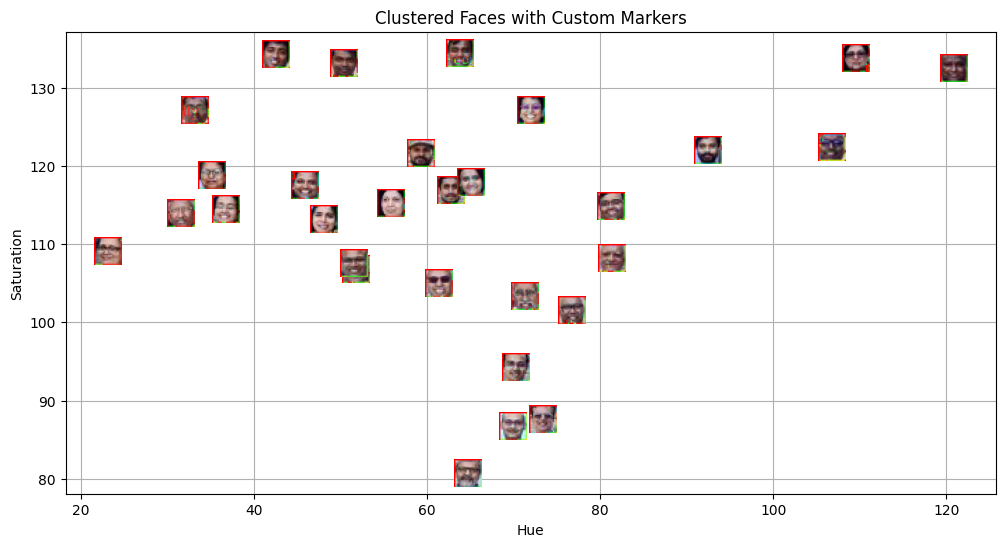

In [8]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.metrics import silhouette_score

# Extract face region features (Hue and Saturation)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # call the img and convert it from BGR to HSV and store in img_hsv
hue_saturation = []
face_images = []  # To store detected face images

start_time = time.time()  # Start timing for runtime

for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)

hue_saturation = np.array(hue_saturation)

## Perform k-Means clustering on hue_saturation and store in kmeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(hue_saturation)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Log runtime, inertia, and silhouette score
end_time = time.time()
silhouette = silhouette_score(hue_saturation, kmeans.labels_)
wandb.log({
    "Runtime (seconds)": end_time - start_time,
    "Inertia": kmeans.inertia_,
    "Silhouette Score": silhouette
})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers
for i, (x, y, w, h) in enumerate(faces_rect):
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1])

# Put x label
plt.xlabel('Hue')
# Put y label
plt.ylabel('Saturation')
# Put title
plt.title('Clustered Faces with Custom Markers')
# Put grid
plt.grid(True)

## Show the plot and log it
plt.savefig('initial_clustering_plot.png')
wandb.log({"Initial Clustering Plot": wandb.Image('initial_clustering_plot.png')})
plt.show()

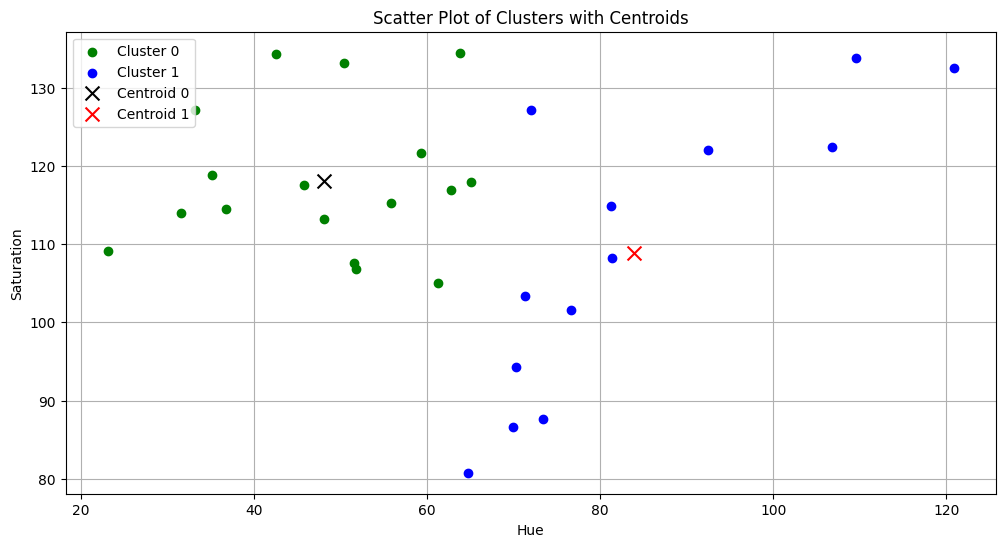

In [9]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))

cluster_0_points = np.array(cluster_0_points)
# Plot points for cluster 0 in green
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], c='green', label='Cluster 0')

cluster_1_points = np.array(cluster_1_points)
# Plot points for cluster 1 in blue
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], c='blue', label='Cluster 1')

# Calculate and plot centroids
centroid_0 = centroids[0]
centroid_1 = centroids[1]

# Plot both the centroid for cluster 0 and cluster 1 
plt.scatter(centroid_0[0], centroid_0[1], c='black', marker='x', s=100, label='Centroid 0')
plt.scatter(centroid_1[0], centroid_1[1], c='red', marker='x', s=100, label='Centroid 1')

## Put x label
plt.xlabel('Hue')
## Put y label
plt.ylabel('Saturation')
## Put title
plt.title('Scatter Plot of Clusters with Centroids')
## Add a legend
plt.legend()
## Add grid
plt.grid(True)

## Show the plot and log it
plt.savefig('clusters_centroids_plot.png')
wandb.log({"Clusters and Centroids Plot": wandb.Image('clusters_centroids_plot.png')})
plt.show()

In [10]:
## Read the class of the template image 'Dr_Shashi_Tharoor.jpg' using cv2 and store it in template_img
template_img = cv2.imread('/kaggle/input/lab-5-images/Dr_Shashi_Tharoor.jpg')

# Convert the template image to grayscale
gray_template_img = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)

# Detect face in the template image after converting it to gray and store it in template_faces
template_faces = face_cascade.detectMultiScale(gray_template_img, 1.05, 4, minSize=(25, 25), maxSize=(50, 50))

# Draw rectangles around the detected faces
for (x, y, w, h) in template_faces:
    cv2.rectangle(template_img, (x, y), (x + w, y + h), (0, 255, 0), 3)

# Display the image and window title should be "Template Image with Detected Faces"
# cv2.imshow('Template Image with Detected Faces', template_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Log the template face detection image
cv2.imwrite('template_face_detected.png', template_img)
wandb.log({"Template Face Detected": wandb.Image('template_face_detected.png')})

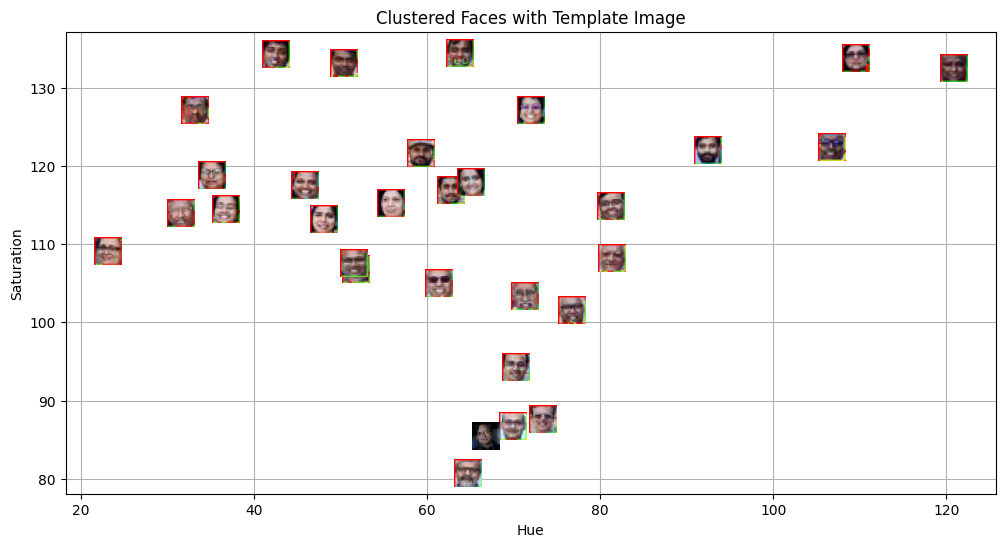

In [11]:
# Convert the template image to HSV color space and store it in template_hsv
template_hsv = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)

# Extract hue and saturation features from the template image as we did it for detected faces.
template_hue = np.mean(template_hsv[:, :, 0])
template_saturation = np.mean(template_hsv[:, :, 1])

# Predict the cluster label for the template image and store it in template_label
template_label = kmeans.predict([[template_hue, template_saturation]])[0]

# Create a figure and axis for visualization
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the clustered faces with custom markers (similar to previous code)
for i, (x, y, w, h) in enumerate(faces_rect):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'
    im = OffsetImage(cv2.cvtColor(cv2.resize(face_images[i], (20, 20)), cv2.COLOR_HSV2RGB))
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax.add_artist(ab)
    plt.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', markersize=5, color=color)

# Plot the template image in the respective cluster
if template_label == 0:
    color = 'red'
else:
    color = 'blue'
im = OffsetImage(cv2.cvtColor(cv2.resize(template_img, (20, 20)), cv2.COLOR_BGR2RGB))
ab = AnnotationBbox(im, (template_hue, template_saturation), frameon=False, pad=0)
ax.add_artist(ab)

# Put x label
plt.xlabel('Hue')
# Put y label
plt.ylabel('Saturation')
# Put title
plt.title('Clustered Faces with Template Image')
# Add grid
plt.grid(True)

## Show plot and log it
plt.savefig('template_clustering_plot.png')
wandb.log({"Template Clustering Plot": wandb.Image('template_clustering_plot.png')})
plt.show()

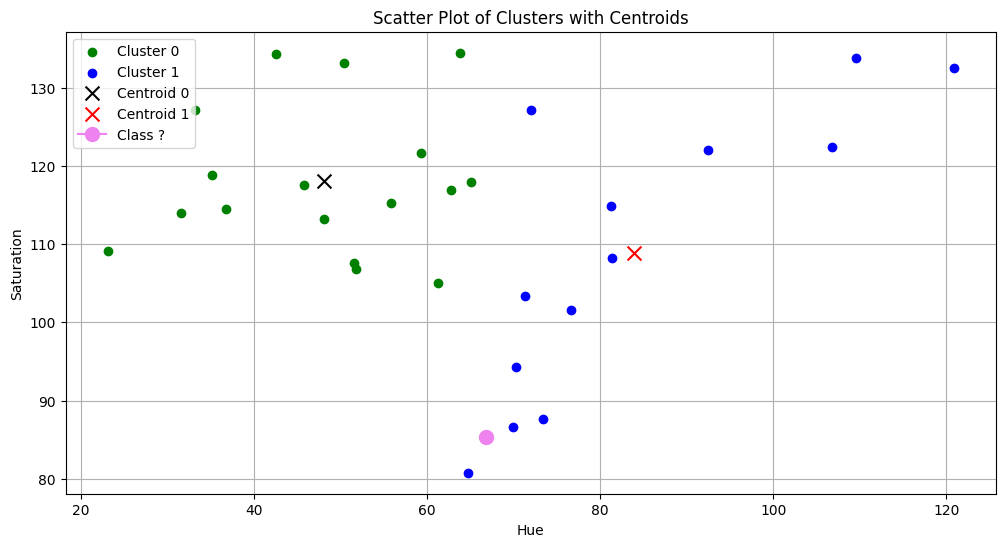

Inertia,▁
Number of Faces Detected,▁
Runtime (seconds),▁
Silhouette Score,▁
Inertia,11778.62059
Number of Faces Detected,30
Runtime (seconds),0.00933
Silhouette Score,0.40052


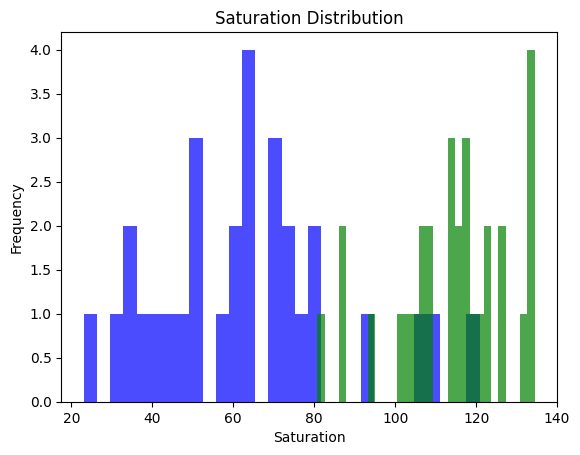

In [12]:
# Create an empty list to store legend labels
legend_labels = []

# Create lists to store points for each cluster
cluster_0_points = []
cluster_1_points = []

# Your code for scatter plot goes here
fig, ax = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    if kmeans.labels_[i] == 0:
        cluster_0_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))
    else:
        cluster_1_points.append((hue_saturation[i, 0], hue_saturation[i, 1]))

# Plot points for cluster 0 in green
cluster_0_points = np.array(cluster_0_points)
plt.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], c='green', label='Cluster 0')

# Plot points for cluster 1 in blue
cluster_1_points = np.array(cluster_1_points)
plt.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], c='blue', label='Cluster 1')

# Calculate and plot centroids for both the clusters
centroid_0 = centroids[0]
centroid_1 = centroids[1]
plt.scatter(centroid_0[0], centroid_0[1], c='black', marker='x', s=100, label='Centroid 0')  # plot for centroid 0
plt.scatter(centroid_1[0], centroid_1[1], c='red', marker='x', s=100, label='Centroid 1')  # plot for centroid 1
plt.plot(template_hue, template_saturation, marker='o', c='violet', markersize=10, label='Class ?')

# Put x label
plt.xlabel('Hue')
# Put y label
plt.ylabel('Saturation')
# Put title
plt.title('Scatter Plot of Clusters with Centroids')
# Add a legend
plt.legend()
# Add grid
plt.grid(True)

## Show the plot and log it
plt.savefig('final_scatter_plot.png')
wandb.log({"Final Scatter Plot": wandb.Image('final_scatter_plot.png')})
plt.show()

# Log feature histograms
plt.hist(hue_saturation[:, 0], bins=30, color='blue', alpha=0.7)
plt.title('Hue Distribution')
plt.xlabel('Hue')
plt.ylabel('Frequency')
plt.savefig('hue_histogram.png')
wandb.log({"Hue Histogram": wandb.Image('hue_histogram.png')})

plt.hist(hue_saturation[:, 1], bins=30, color='green', alpha=0.7)
plt.title('Saturation Distribution')
plt.xlabel('Saturation')
plt.ylabel('Frequency')
plt.savefig('saturation_histogram.png')
wandb.log({"Saturation Histogram": wandb.Image('saturation_histogram.png')})

# Finish the Wandb run
wandb.finish()